<a href="https://www.kaggle.com/code/subhadipde2000/context-aware-q-a-gemma-3-fine-tuning-with-lora?scriptVersionId=240150108" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Installing/Updating Required Libraries:

In [1]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 11.5 MB/s eta 0:00:00


# Importing Required Libraries:

In [2]:
import os
import json
import keras
import random
import warnings
import keras_nlp
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

2025-05-16 20:50:02.988173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747428603.184304      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747428603.242646      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings("ignore")

# Setting Up the Keras Backend:

In [4]:
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1"
os.environ["JAX_PLATFORMS"] = ""

# Loading the Data:

In [5]:
data = []

with open('/kaggle/input/databricks-dolly-15k/databricks-dolly-15k.jsonl') as file:
    for line in file:
        record = json.loads(line)

        # Filtering out examples without context
        if not record["context"]:
            continue
            
        record_dict = {"prompts" : "", "responses" : ""}
        record_dict["prompts"] = record["instruction"]
        record_dict["prompts"] += f" \n\nContext: {record['context']}"
        record_dict["responses"] = record["response"]
        
        data.append(record_dict)

# Exploratory Data Analysis:

In [6]:
def plot():
    context_lengths = []
    response_lengths = []
    
    for i in range(len(data)):
        context_lengths.append(len(data[i]["prompts"].split("\n\nContext: ")[-1].split()))
        response_lengths.append(len(data[i]["responses"].split()))

    df = pd.DataFrame({"context lengths":context_lengths, "response lengths":response_lengths})
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), dpi=250)
    sns.histplot(data=df, x="context lengths", bins=100, ax=axes[0], kde=True).set_title("Distribution of context lengths (number of words)")
    sns.histplot(data=df, x="response lengths", bins=100, ax=axes[1], kde=True).set_title("Distribution of response lengths (number of words)")
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return

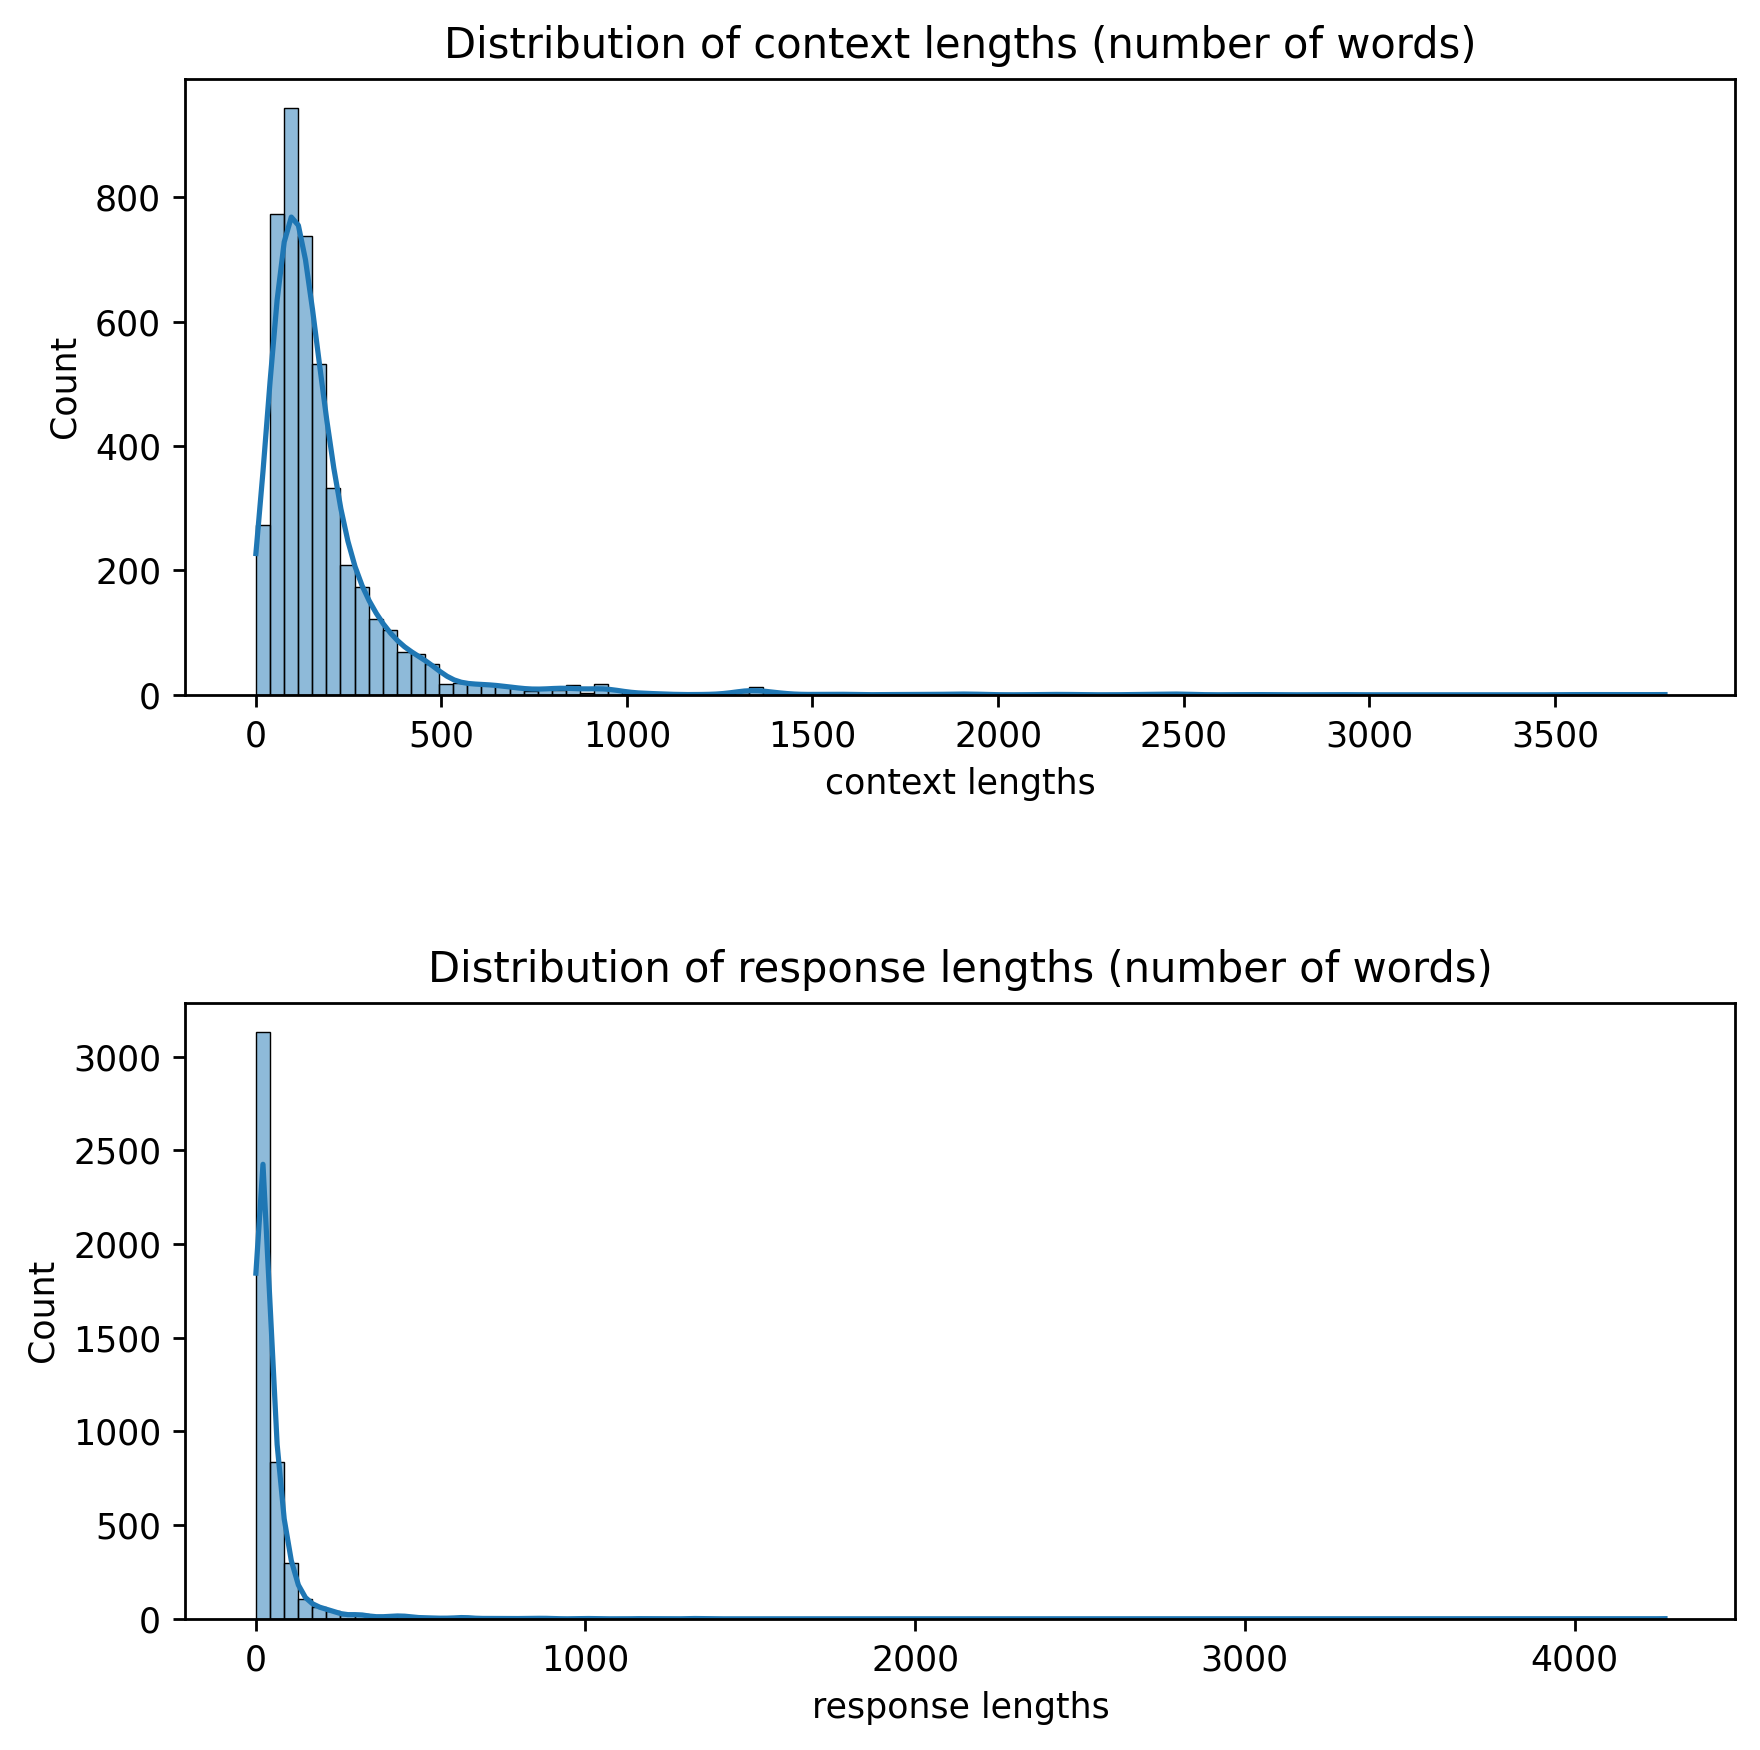

In [7]:
plot()

# Function for Coloring and Formatting the Texts:

In [8]:
def colorize_text(text):
    for word, color in zip(["Question: ", "Context: ", "Answer: ", "System: "], ["crimson", "cyan", "lightgreen", "aquamarine"]):
        text = text.replace(f"{word}", f"<font color='{color}' size='4'><strong>{word}</strong></font>")
    return text



def colorize_text_from_dict(text_dict):
    text = ""

    for key, value in text_dict.items():
        if key == "prompts":
            text += f"Question: {value}\n\n"
        elif key == "responses":
            text += f"Answer: {value}\n\n"

    text = colorize_text(text)
    
    return text

In [9]:
# Visualizing a random text from the corpus
n = random.randint(0, len(data))
text = f"<center><font color='Yellow' size='6'><strong>Example {n}:</strong></center></font>\n\n"
text += colorize_text_from_dict(data[n])
display(Markdown(text))

<center><font color='Yellow' size='6'><strong>Example 1197:</strong></center></font>

<font color='crimson' size='4'><strong>Question: </strong></font>From the passage below, extract the first five member countries of OPEC 

<font color='cyan' size='4'><strong>Context: </strong></font>The Organization of the Petroleum Exporting Countries (OPEC, /ˈoʊpɛk/ OH-pek) is an organization enabling the co-operation of leading oil-producing countries, in order to collectively influence the global market and maximise profit. Founded on 14 September 1960 in Baghdad by the first five members (Iran, Iraq, Kuwait, Saudi Arabia, and Venezuela), it has, since 1965, been headquartered in Vienna, Austria, although Austria is not an OPEC member state. As of September 2018, the 13 member countries accounted for an estimated 44 percent of global oil production and 81.5 percent of the world's proven oil reserves, giving OPEC a major influence on global oil prices that were previously determined by the so-called "Seven Sisters" grouping of multinational oil companies.

The formation of OPEC marked a turning point toward national sovereignty over natural resources, and OPEC decisions have come to play a prominent role in the global oil market and international relations. The effect can be particularly strong when wars or civil disorders lead to extended interruptions in supply. In the 1970s, restrictions in oil production led to a dramatic rise in oil prices and in the revenue and wealth of OPEC, with long-lasting and far-reaching consequences for the global economy. In the 1980s, OPEC began setting production targets for its member nations; generally, when the targets are reduced, oil prices increase. This has occurred most recently from the organization's 2008 and 2016 decisions to trim oversupply.

<font color='lightgreen' size='4'><strong>Answer: </strong></font>The first five members of the Organization of the Petroleum Exporting Countries (OPEC) were Iran, Iraq, Kuwait, Saudi Arabia and Venezuela. As of September 2018, OPEC officially has 13 member countries.



# Building TensorFlow Dataset:

In [10]:
random.shuffle(data) # Shuffling the list
dataset = data[:500] # Taking the first 500 examples for faster training
test_dataset = data[500:]

In [11]:
def build_tf_dataset(text_dict_list):
    AUTO = tf.data.AUTOTUNE
    options = tf.data.Options()
    options.experimental_deterministic = False
    
    dataset = tf.data.Dataset.from_generator(
        lambda: (item for item in text_dict_list),
        output_signature={
            "prompts": tf.TensorSpec(shape=(), dtype=tf.string),
            "responses": tf.TensorSpec(shape=(), dtype=tf.string),
        }
    ).cache()

    dataset = dataset.shuffle(1024, seed=42)
    dataset = dataset.with_options(options).batch(1).prefetch(AUTO)

    return dataset

In [12]:
dataset = build_tf_dataset(dataset)

I0000 00:00:1747428619.918424      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Loading the Gemma 3 Model with 1 Billion Parameters:

In [13]:
gemma3_1b = keras_nlp.models.Gemma3CausalLM.from_preset("gemma3_1b")
gemma3_1b.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │     999,885,952 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 999,885,952 (3.72 GB)

 Trainable params: 999,885,952 (3.72 GB)

 Non-trainable params: 0 (0.00 B)

# Inferenece Before Fine-tuning:

In [14]:
template = """System: 
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

Question: 
{question}

Context: 
{context}

Answer: \n\n
"""

In [15]:
def generate_inference(example_num=None):
    
    if example_num == None or example_num >= len(test_dataset):
        example_num = random.randint(0, len(test_dataset))

    example = test_dataset[example_num]
    question = example["prompts"].split("\n\nContext: ")[0]
    context = example["prompts"].split("\n\nContext: ")[-1]
    answer = example["responses"]

    input_prompt = template.format(question=question, context=context)
    max_length = 2 * len(input_prompt.split())
    response = gemma3_1b.generate(input_prompt, max_length=max_length)
    response = response.split("Answer: \n\n")[-1].strip()

    colored_text = f"<center><font color='Yellow' size='6'><strong>Input Prompt for Example Number {example_num}:</strong></center></font>\n\n"
    colored_text += colorize_text(input_prompt)
    colored_text += f"<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></center></font>\n\n{answer}\n\n"
    colored_text += f"<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>\n\n"
    colored_text += colorize_text(response)
    
    colored_text += f"{colorize_text(response)}"
    
    return colored_text

In [16]:
display(Markdown(generate_inference()))

I0000 00:00:1747428659.140967      19 service.cc:148] XLA service 0x4362b9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747428659.141965      19 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747428665.615755      19 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747428677.424174      19 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<center><font color='Yellow' size='6'><strong>Input Prompt for Example Number 3551:</strong></center></font>

<font color='aquamarine' size='4'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='4'><strong>Question: </strong></font>
What is the biggest strength of Hong Kong journalists 

<font color='cyan' size='4'><strong>Context: </strong></font>
In the first video, Jiang lashed out at Hong Kong journalist Sharon Cheung in Zhongnanhai when he met with Chee-hwa Tung, Chief Executive of Hong Kong at that time. Ms. Cheung asked if Jiang supported Tung's campaign for Chief Executive, which Jiang affirmed. Cheung then asked if it meant the Chinese government had already decided internally to re-appoint Tung. This made Jiang very upset, and criticized her for twisting his words to "make big news." Jiang then continued to criticize the Hong Kong media on the whole, claiming that they need to learn to ask more meaningful questions, even stating that "Mike Wallace of the US is at a much higher level than you are", referring to a 2000 interview Jiang gave with 60 Minutes.
The second is the famous interview by American journalist Mike Wallace that Jiang referred to in the previous video. In this interview, Wallace and Jiang talked about many touchy subjects, such as democracy and dictatorship in China, freedom of the press, Falun Gong, and the 1989 Tiananmen Square protests.
The third video is recorded when Jiang came back to China United Engineering Corporation (Jiang worked there for some years), and Jiang recalled his experience in the video. He also talks about Deng Xiaoping's decision to appoint him as leader of China, and what he considered his achievements during his years of leadership.

<font color='lightgreen' size='4'><strong>Answer: </strong></font>


<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></center></font>

Making big news

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>

The biggest strength of Hong Kong journalists is their ability to ask meaningful questions. They are able to challenge the status quo and ask questions that go beyond the surface level. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and digThe biggest strength of Hong Kong journalists is their ability to ask meaningful questions. They are able to challenge the status quo and ask questions that go beyond the surface level. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig deeper into the issues at hand. They are able to ask questions that go beyond the surface level and dig

In [17]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt for Example Number 1082:</strong></center></font>

<font color='aquamarine' size='4'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='4'><strong>Question: </strong></font>
Please write a summary of the kinds of vehicles that are used for ambulances. 

<font color='cyan' size='4'><strong>Context: </strong></font>
Vehicle types
In North America (US and Canada), there are four types of ambulances. There are Type I, Type II, Type III, and Type IV. Type I is based upon a heavy truck chassis-cab with a custom rear compartment that is often referred to as a "box" or "module." Type I ambulances are primarily used for Advanced Life Support (ALS), also referred to as Mobile Intensive Care Unit (MICU) in some jurisdictions, and rescue work. A Type II ambulance is based on a commercial heavy-duty van with few modifications except for a raised roof and a secondary air conditioning unit for the rear of the vehicle. These types of ambulances are primarily used for Basic Life Support (BLS) and transfer of patients but it is not uncommon to find them used for advanced life support and rescue. Type III is a van chassis-cab but with a custom-made rear compartment and has the same uses as Type I ambulances. Type IV is for smaller ad hoc patient transfer that use smaller utility vehicles in which passenger vehicles and trucks would have difficulty in traversing, such as large industrial complexes, commercial venues, and special events with large crowds; they generally do not fall under Federal Regulations.[15][16][17]

Ambulances can be based on many types of vehicle although emergency and disaster conditions may lead to other vehicles serving as makeshift ambulances:


A modern American ambulance built on the chassis of a Ford F-450 truck, with extensive external storage

Many modern Canadian and European ambulances are built on the Mercedes-Benz Sprinter chassis. Some, like this Niagara Region example, use custom rear compartments.
Van or pickup truck – A typical general-purpose ambulance is based on either the chassis of a van (vanbulance) or a light-duty truck. This chassis is then modified to the designs and specifications of the purchaser. Vans may either retain their original body and be upfitted inside, or may be based on a chassis without the original body with a modular box body fitted instead. Those based on pickup trucks almost always have modular bodies. Those vehicles intended for especially intensive care or require a large amount of equipment to be carried may be based on medium-duty trucks.
Car – Used either as a fly-car for rapid response[2] or to transport patients who can sit, these are standard car models adapted to the requirements of the service using them. Some cars are capable of taking a stretcher with a recumbent patient, but this often requires the removal of the front passenger seat, or the use of a particularly long car. This was often the case with early ambulances, which were converted (or even serving) hearses, as these were some of the few vehicles able to accept a human body in a supine position. Some operators use modular-body transport ambulances based on the chassis of a minivan and station wagon.
Motorcycle and motor scooter – In urban areas, these may be used for rapid response in an emergency[18] as they can travel through heavy traffic much faster than a car or van. Trailers or sidecars can make these patient transporting units.[19][20] See also motorcycle ambulance.

Patient being loaded into a medical helicopter
Bicycle – Used for response, but usually in pedestrian-only areas where large vehicles find access difficult.[21][22] Like the motorcycle ambulance, a bicycle may be connected to a trailer for patient transport, most often in the developing world.[23] See also cycle responder.
All-terrain vehicle (ATV) – for example quad bikes; these are used for response off-road,[24] especially at events. ATVs can be modified to carry a stretcher, and are used for tasks such as mountain rescue in inaccessible areas.

Golf Cart converted into an ambulance
Golf cart or Neighborhood Electric Vehicle – Used for rapid response at events[25] or on campuses. These function similarly to ATVs, with less rough terrain capability, but with less noise.
Helicopter – Usually used for emergency care, either in places inaccessible by road, or in areas where speed is of the essence, as they are able to travel significantly faster than a road ambulance.[26] Helicopter and fixed-wing ambulances are discussed in greater detail at air ambulance.
Fixed-wing aircraft – These can be used for either acute emergency care in remote areas (such as in Australia, with the 'Flying Doctors'[27]), for patient transport over long distances (e.g. a re-patriation following an illness or injury in a foreign country[28]), or transportation between distant hospitals. Helicopter and fixed-wing ambulances are discussed in greater detail at air ambulance.
Boat – Boats can be used to serve as ambulances, especially in island areas[29] or in areas with a large number of canals, such as the Venetian water ambulances. Some lifeboats or lifeguard vessels may fit the description of an ambulance as they are used to transport a casualty.
Bus – In some cases, buses can be used for multiple casualty transport, either for the purposes of taking patients on journeys,[10] in the context of major incidents, or to deal with specific problems such as drunken patients in town centres.[30][31] Ambulance buses are discussed at greater length in their own article.
Trailer – In some instances a trailer, which can be towed behind a self-propelled vehicle can be used. This permits flexibility in areas with minimal access to vehicles, such as on small islands.[32]
Horse and cart – Especially in developing world areas, more traditional methods of transport include transport such as horse and cart, used in much the same way as motorcycle or bicycle stretcher units to transport to a local clinic.
Fire engine – Fire services (especially in North America) often train firefighters to respond to medical emergencies and most apparatuses carry at least basic medical supplies. By design, most apparatuses cannot transport patients unless they can sit in the cab.

<font color='lightgreen' size='4'><strong>Answer: </strong></font>


<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></center></font>

The most common types of vehicle used as an ambulance are cars, vans or pickup trucks. Depending on many factors, such as accessibility to the patient and/or medical services or the urgency of treatment, other types of vehicles are used as well, including: bicycles, all-terrain vehicles, golf carts, helicopters, fixed-wing aircraft, boats, busses, trailers, horse and cart, and fire engines.

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>

<font color='aquamarine' size='4'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='4'><strong>Question: </strong></font>
Please write a summary of the kinds of vehicles that are used for ambulances. 

<font color='cyan' size='4'><strong>Context: </strong></font>
Vehicle types
In North America (US and Canada), there are four types of ambulances. There are Type I, Type II, Type III, and Type IV. Type I is based upon a heavy truck chassis-cab with a custom rear compartment that is often referred to as a "box" or "module." Type I ambulances are primarily used for Advanced Life Support (ALS), also referred to as Mobile Intensive Care Unit (MICU) in some jurisdictions, and rescue work. A Type II ambulance is based on a commercial heavy-duty van with few modifications except for a raised roof and a secondary air conditioning unit for the rear of the vehicle. These types of ambulances are primarily used for Basic Life Support (BLS) and transfer of patients but it is not uncommon to find them used for advanced life support and rescue. Type III is a van chassis-cab but with a custom-made rear compartment and has the same uses as Type I ambulances. Type IV is for smaller ad hoc patient transfer that use smaller utility vehicles in which passenger vehicles and trucks would have difficulty in traversing, such as large industrial complexes, commercial venues, and special events with large crowds; they generally do not fall under Federal Regulations.[15][16][17]

Ambulances can be based on many types of vehicle although emergency and disaster conditions may lead to other vehicles serving as makeshift ambulances:


A modern American ambulance built on the chassis of a Ford F-450 truck, with extensive external storage

Many modern Canadian and European ambulances are built on the Mercedes-Benz Sprinter chassis. Some, like this Niagara Region example, use custom rear compartments.
Van or pickup truck – A typical general-purpose ambulance is based on either the chassis of a van (vanbulance) or a light-duty truck. This chassis is then modified to the designs and specifications of the purchaser. Vans may either retain their original body and be upfitted inside, or may be based on a chassis without the original body with a modular box body fitted instead. Those based on pickup trucks almost always have modular bodies. Those vehicles intended for especially intensive care or require a large amount of equipment to be carried may be based on medium-duty trucks.
Car – Used either as a fly-car for rapid response[2] or to transport patients who can sit, these are standard car models adapted to the requirements of the service using them. Some cars are capable of taking a stretcher with a recumbent patient, but this often requires the removal of the front passenger seat, or the use of a particularly long car. This was often the case with early ambulances, which were converted (or even serving) hearses, as these were some of the few vehicles able to accept a human body in a supine position. Some operators use modular-body transport ambulances based on the chassis of a minivan and station wagon.
Motorcycle and motor scooter – In urban areas, these may be used for rapid response in an emergency[18] as they can travel through heavy traffic much faster than a car or van. Trailers or sidecars can make these patient transporting units.[19][20] See also motorcycle ambulance.

Patient being loaded into a medical helicopter
Bicycle – Used for response, but usually in pedestrian-only areas where large vehicles find access difficult.[21][22] Like the motorcycle ambulance, a bicycle may be connected to a trailer for patient transport, most often in the developing world.[23] See also cycle responder.
All-terrain vehicle (ATV) – for example quad bikes; these are used for response off-road,[24] especially at events. ATVs can be modified to carry a stretcher, and are used for tasks such as mountain rescue in inaccessible areas.

Golf Cart converted into an ambulance
Golf cart or Neighborhood Electric Vehicle – Used for rapid response at events[25] or on campuses. These function similarly to ATVs, with less rough terrain capability, but with less noise.
Helicopter – Usually used for emergency care, either in places inaccessible by road, or in areas where speed is of the essence, as they are able to travel significantly faster than a road ambulance.[26] Helicopter and fixed-wing ambulances are discussed in greater detail at air ambulance.
Fixed-wing aircraft – These can be used for either acute emergency care in remote areas (such as in Australia, with the 'Flying Doctors'[27]), for patient transfer, or for rapid response to disasters. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Hovercraft – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Jet ski – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Jetpack – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized wheelchair – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized tricycle – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized wheelchair – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized tricycle – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized tricycle – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized wheelchair – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized tricycle – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized tricycle – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized tricycle – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the<font color='aquamarine' size='4'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='4'><strong>Question: </strong></font>
Please write a summary of the kinds of vehicles that are used for ambulances. 

<font color='cyan' size='4'><strong>Context: </strong></font>
Vehicle types
In North America (US and Canada), there are four types of ambulances. There are Type I, Type II, Type III, and Type IV. Type I is based upon a heavy truck chassis-cab with a custom rear compartment that is often referred to as a "box" or "module." Type I ambulances are primarily used for Advanced Life Support (ALS), also referred to as Mobile Intensive Care Unit (MICU) in some jurisdictions, and rescue work. A Type II ambulance is based on a commercial heavy-duty van with few modifications except for a raised roof and a secondary air conditioning unit for the rear of the vehicle. These types of ambulances are primarily used for Basic Life Support (BLS) and transfer of patients but it is not uncommon to find them used for advanced life support and rescue. Type III is a van chassis-cab but with a custom-made rear compartment and has the same uses as Type I ambulances. Type IV is for smaller ad hoc patient transfer that use smaller utility vehicles in which passenger vehicles and trucks would have difficulty in traversing, such as large industrial complexes, commercial venues, and special events with large crowds; they generally do not fall under Federal Regulations.[15][16][17]

Ambulances can be based on many types of vehicle although emergency and disaster conditions may lead to other vehicles serving as makeshift ambulances:


A modern American ambulance built on the chassis of a Ford F-450 truck, with extensive external storage

Many modern Canadian and European ambulances are built on the Mercedes-Benz Sprinter chassis. Some, like this Niagara Region example, use custom rear compartments.
Van or pickup truck – A typical general-purpose ambulance is based on either the chassis of a van (vanbulance) or a light-duty truck. This chassis is then modified to the designs and specifications of the purchaser. Vans may either retain their original body and be upfitted inside, or may be based on a chassis without the original body with a modular box body fitted instead. Those based on pickup trucks almost always have modular bodies. Those vehicles intended for especially intensive care or require a large amount of equipment to be carried may be based on medium-duty trucks.
Car – Used either as a fly-car for rapid response[2] or to transport patients who can sit, these are standard car models adapted to the requirements of the service using them. Some cars are capable of taking a stretcher with a recumbent patient, but this often requires the removal of the front passenger seat, or the use of a particularly long car. This was often the case with early ambulances, which were converted (or even serving) hearses, as these were some of the few vehicles able to accept a human body in a supine position. Some operators use modular-body transport ambulances based on the chassis of a minivan and station wagon.
Motorcycle and motor scooter – In urban areas, these may be used for rapid response in an emergency[18] as they can travel through heavy traffic much faster than a car or van. Trailers or sidecars can make these patient transporting units.[19][20] See also motorcycle ambulance.

Patient being loaded into a medical helicopter
Bicycle – Used for response, but usually in pedestrian-only areas where large vehicles find access difficult.[21][22] Like the motorcycle ambulance, a bicycle may be connected to a trailer for patient transport, most often in the developing world.[23] See also cycle responder.
All-terrain vehicle (ATV) – for example quad bikes; these are used for response off-road,[24] especially at events. ATVs can be modified to carry a stretcher, and are used for tasks such as mountain rescue in inaccessible areas.

Golf Cart converted into an ambulance
Golf cart or Neighborhood Electric Vehicle – Used for rapid response at events[25] or on campuses. These function similarly to ATVs, with less rough terrain capability, but with less noise.
Helicopter – Usually used for emergency care, either in places inaccessible by road, or in areas where speed is of the essence, as they are able to travel significantly faster than a road ambulance.[26] Helicopter and fixed-wing ambulances are discussed in greater detail at air ambulance.
Fixed-wing aircraft – These can be used for either acute emergency care in remote areas (such as in Australia, with the 'Flying Doctors'[27]), for patient transfer, or for rapid response to disasters. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Hovercraft – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Jet ski – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Jetpack – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized wheelchair – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized tricycle – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized wheelchair – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized tricycle – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized tricycle – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized wheelchair – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized tricycle – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized tricycle – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized tricycle – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the 2004 Indian Ocean earthquake.
Motorized scooter – These are used for rapid response in areas where roads are impassable, or where roads are impassable but there is no road access. They are also used for disaster relief, such as in the aftermath of the

# Fine-tuning with LoRA:

In [18]:
gemma3_1b.backbone.enable_lora(rank=4)
gemma3_1b.summary()

Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │   1,000,538,240 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,000,538,240 (3.73 GB)

 Trainable params: 652,288 (2.49 MB)

 Non-trainable params: 999,885,952 (3.72 GB)

In [19]:
gemma3_1b.preprocessor.sequence_length = 1024

optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)

# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

In [20]:
gemma3_1b.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [21]:
history = gemma3_1b.fit(dataset, epochs=25)

Epoch 1/25


W0000 00:00:1747428818.265338      75 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


500/500 ━━━━━━━━━━━━━━━━━━━━ 420s 628ms/step - loss: 0.0918 - sparse_categorical_accuracy: 0.7186
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0904 - sparse_categorical_accuracy: 0.7206
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0961 - sparse_categorical_accuracy: 0.7369
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0729 - sparse_categorical_accuracy: 0.7613
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0753 - sparse_categorical_accuracy: 0.7581
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0888 - sparse_categorical_accuracy: 0.7383
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0820 - sparse_categorical_accuracy: 0.7652
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0758 - sparse_categorical_accuracy: 0.7578
Epoch 9/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0733 - sparse_categorical_accuracy: 0.7611
Epoch 10/25
500/500 ━━━━━━━━━━

# Plotting Training Metric:

In [22]:
def plot_model_metric(metric):
    plt.figure(dpi=120)
    plt.plot(history.history[metric], label=metric)
    # plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'{metric} over Epochs')
    plt.show();

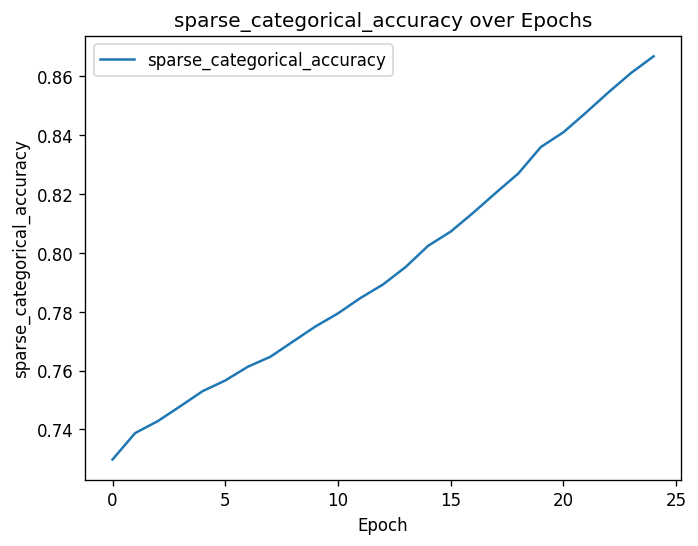

In [23]:
plot_model_metric('sparse_categorical_accuracy')

# Inference After Fine-tuning:

In [24]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt for Example Number 2178:</strong></center></font>

<font color='aquamarine' size='4'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='4'><strong>Question: </strong></font>
List the types of pasta that can be used to make carbonara 

<font color='cyan' size='4'><strong>Context: </strong></font>
Carbonara (Italian: [karboˈnaːra]) is a Roman pasta dish made with eggs, hard cheese, cured pork and black pepper. The dish took its modern form and name in the middle of the 20th century.

The cheese is usually Pecorino Romano, Parmigiano-Reggiano, or a combination of the two. Spaghetti is the most common pasta, but fettuccine, rigatoni, linguine, or bucatini are also used. Normally guanciale or pancetta are used for the meat component, but lardons of smoked bacon are a common substitute outside Italy.

<font color='lightgreen' size='4'><strong>Answer: </strong></font>


<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></center></font>

Spaghetti, fettuccine, rigatoni, linguine, bucatini

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>

Pecorino Romano, Parmigiano-Reggiano, or a combination of the two
Spaghetti, fettuccine, rigatoni, linguine, or bucatiniPecorino Romano, Parmigiano-Reggiano, or a combination of the two
Spaghetti, fettuccine, rigatoni, linguine, or bucatini

In [25]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt for Example Number 2416:</strong></center></font>

<font color='aquamarine' size='4'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='4'><strong>Question: </strong></font>
From the given paragraph, extract the industry sector and the corresponding percentage of GDP in the format {Industry sector} - {Percentage} and list them using bullets 

<font color='cyan' size='4'><strong>Context: </strong></font>
The 522-million-worker Indian labour force is the world's second-largest, as of 2017.[288] The service sector makes up 55.6% of GDP, the industrial sector 26.3% and the agricultural sector 18.1%. India's foreign exchange remittances of US$100 billion in 2022,[308] highest in the world, were contributed to its economy by 32 million Indians working in foreign countries.[309] Major agricultural products include: rice, wheat, oilseed, cotton, jute, tea, sugarcane, and potatoes.[16]

<font color='lightgreen' size='4'><strong>Answer: </strong></font>


<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></center></font>

Here are the industries mentioned in the text and their GDP percentages:
Service sector - 55.6%
Industrial sector - 26.3%
Agricultural sector - 18.1%

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>

The Indian labour force is the second-largest in the world, comprising 55.6% of GDP. The service sector makes up 55.6% of GDP, the industrial sector 26.3% and the agricultural sector 18.1%. India's foreign exchange remittances of US$100 billion inThe Indian labour force is the second-largest in the world, comprising 55.6% of GDP. The service sector makes up 55.6% of GDP, the industrial sector 26.3% and the agricultural sector 18.1%. India's foreign exchange remittances of US$100 billion in